# Swift UVOT Events

## Reading in Data

In [687]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Angle, SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import TimeSeries
from astropy.timeseries import BinnedTimeSeries
from astropy.timeseries import aggregate_downsample
from astropy import units as u
from astropy.time import Time
from astropy.time import TimeGPS

from regions import CircleSkyRegion
from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
eventFile = fits.open('/home/saphio/sw00094137009um2w1po_uf.evt.gz')
imgFile = fits.open('/home/saphio/sw00094137009u_sk.img.gz')

primaryHdu = imgFile[0]
imgHdu = imgFile[1]

wcs = WCS(imgHdu.header)

events = eventFile[1].data

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59236.264051 from DATE-OBS.
Set MJD-END to 59236.548553 from DATE-END'. [astropy.wcs.wcs]


In [5]:
events

FITS_rec([(6.32983520e+08,   1867,   1370, 1916, 1439, 2238, 1547, 1,   0),
          (6.32983520e+08,   1534,   1402, 1593, 1476, 2137, 1857, 1,   0),
          (6.32983520e+08,   2039,   1420, 2079, 1486, 2348, 1419, 1,   0),
          ...,
          (6.33013801e+08,   1164,   1636, 1229, 1718, 2616, 2093, 6, 256),
          (6.33013801e+08,    347,   1727,  432, 1810, 2294, 2827, 6, 256),
          (6.33013801e+08,   1453,   1997, 1503, 2069, 3058, 2034, 6, 256)],
         dtype=(numpy.record, [('TIME', '>f8'), ('RAWX', '>i2'), ('RAWY', '>i2'), ('DETX', '>i2'), ('DETY', '>i2'), ('X', '>i2'), ('Y', '>i2'), ('EXPREF', '>i2'), ('QUALITY', '>i2')]))

In [6]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 116.110733 3.551811 
CRPIX : 1604.5 1583.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.000139444442 0.000139444442 
NAXIS : 3208  3166

## Cleaning Event Data

In [7]:
events_clean = events[np.where((events.QUALITY == 0))]
## quality flag of 0 = good
print(f'removed {len(events) - len(events_clean)} events')

removed 1952995 events


## Displaying Event Data

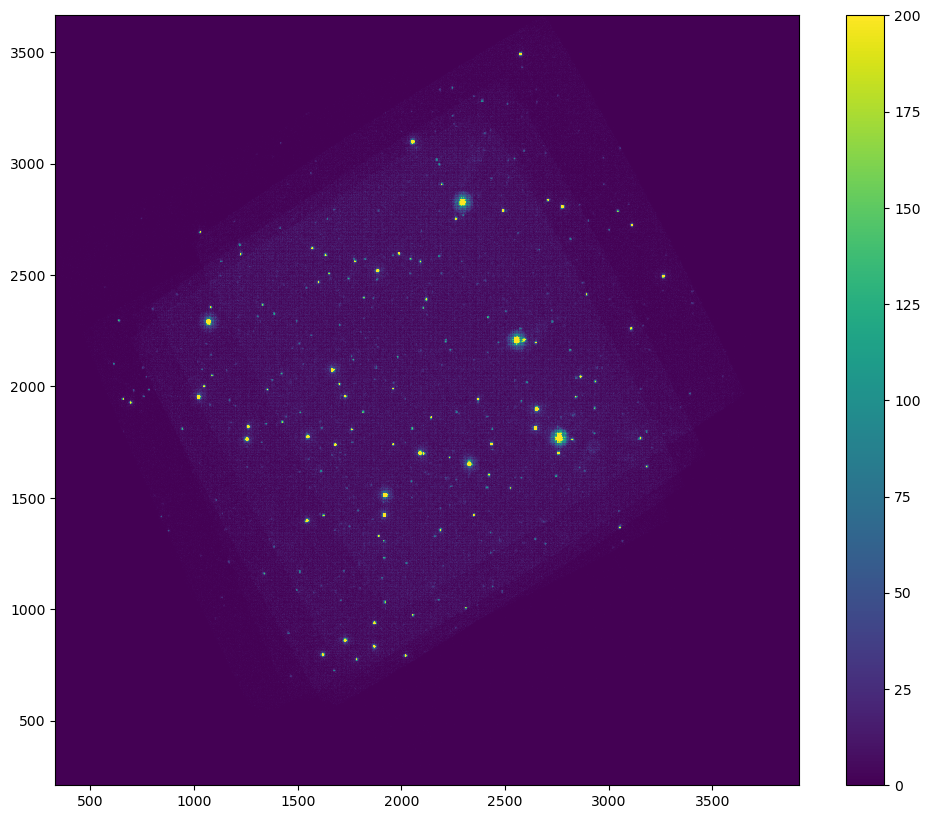

In [141]:
fig, ax = plt.subplots(figsize=(12, 10))

#plt.subplot(projection=wcs)

histdata, x_bins, y_bins, img = plt.hist2d(events_clean.X, events_clean.Y, bins=1000, vmin=0, vmax=200)
plt.colorbar()

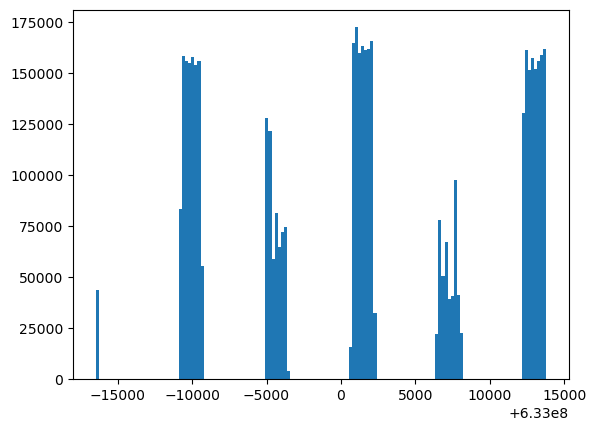

In [10]:
times = plt.hist(events_clean['TIME'], bins='auto')

## Star-finding

In [388]:
## import annulus
from PIL import Image
im_frame = Image.open('/home/saphio/repo/counting_stars/annuli_imgs/annulus_22.png')
## these stars are smaller, so we use the smaller annulus

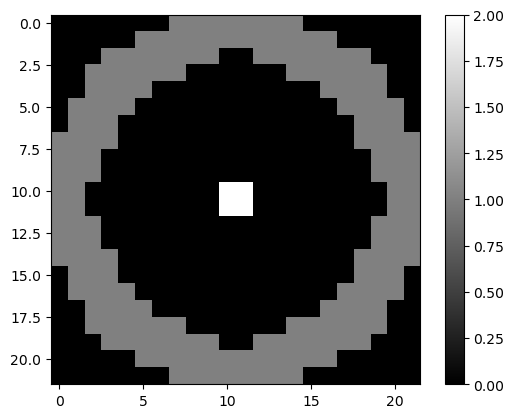

In [13]:
np_frame = np.array(im_frame)
annulus_size = len(np_frame)

## fix up imported annulus
annulus = np.zeros((annulus_size, annulus_size))
for i in range(annulus_size):
    for j in range(annulus_size):
        if (np_frame[i, j, 0] == 0 and np_frame[i, j, 3] == 255):
            annulus[i, j] = 1 ## background
        elif (np_frame[i, j, 0] == 112):
            annulus[i, j] = 2 ## star (circle aperture)
            
plt.imshow(annulus, cmap='gray')
plt.colorbar()

### Signal to Noise Ratio

In [16]:
## signal-to-noise ratio function from counting_stars_v5

def calculate_ratio (testImg, x, y):
    ## Summing counts

    circle_counts = 0
    annulus_counts = 0
    
    circle_pixels = 0
    annulus_pixels = 0

    for i in range(annulus_size):
        for j in range(annulus_size):
            try:
                if (annulus[i, j] == 2):
                    circle_counts += testImg[i + x, j + y]
                    circle_pixels += 1
                elif (annulus[i, j] == 1):
                    annulus_counts += testImg[i + x, j + y]
                    annulus_pixels += 1
            except:
                pass
                
    # Sky background per Pixel (N_s)
    sky_bg_pixel = annulus_counts / annulus_pixels

    # Signal in Aperture (N_T)
    signal = (circle_counts - (circle_pixels * annulus_counts / annulus_pixels))
    
    # Total noise = sqrt(N_T + N_s * npix + other stuff (dark current, readout))
    total_noise = np.sqrt(signal + (circle_pixels * annulus_counts / annulus_pixels))
    
    if (total_noise == 0):
        total_noise = 0.01
    
    return signal/total_noise

(1000, 1000)

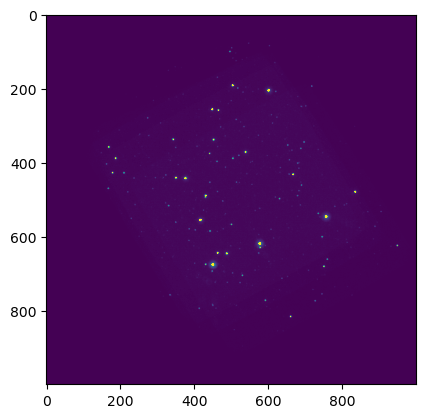

In [390]:
testImg = histdata
plt.imshow(testImg, vmin=0, vmax=500)
testImg.shape

In [18]:
snrImg = np.zeros(testImg.shape)
offset = int((annulus_size + 1)/2)
for i in range(-offset, len(testImg) - offset):
    for j in range(-offset, len(testImg[0]) - offset):
        snrImg[i + offset, j + offset] = calculate_ratio(testImg, i, j)

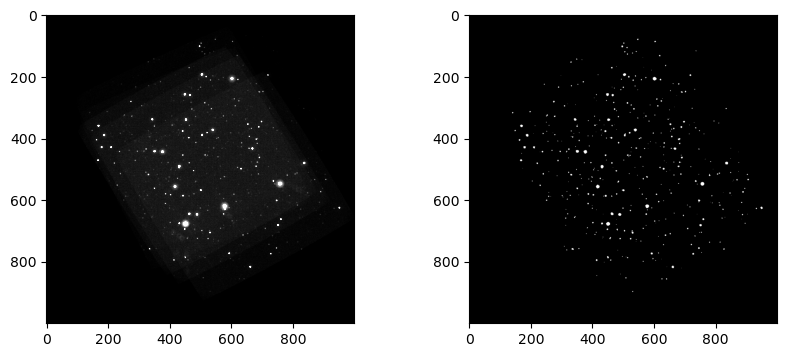

In [32]:
threshold = 5

## apply threshold on testImg
imgCut = np.zeros(snrImg.shape)

for i in range(len(snrImg)):
    for j in range(len(snrImg[0])):
        if (snrImg[i, j] >= threshold):
            imgCut[i, j] = 100
        else:
            imgCut[i, j] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes[0].imshow(testImg, cmap='gray', vmin=0, vmax=100)
axes[1].imshow(imgCut, cmap='gray')

### Counting the Stars

In [393]:
def hasNeighborAbove (matrix, i, j):
    try:
        if (matrix[i - 1][j - 2] or
            matrix[i - 1][j - 1] or
            matrix[i - 1][j] or
            matrix[i - 1][j + 1] or
            matrix[i - 1][j + 2] or
            matrix[i][j - 1]):
            return 0
        else:
            return 1
    except:
        return -1

In [34]:
matrix = [[False for i in range(len(testImg[0]))] for j in range(len(testImg))]

count = 0

for i in range(len(imgCut)):
    for j in range(len(imgCut[0])):
        if (imgCut[i, j] == 100):
            matrix[i][j] = True
            if (hasNeighborAbove(matrix, i, j) == 1):
                count += 1
        else:
            matrix[i][j] = False

In [35]:
count

421

## Star Data
Access stars by coordinates, SNR ratio, and display them by index.

In [627]:
class StarData:
    stars = []
    coords = []
    SNRs = []
    
    def __init__ (self, stars):
        self.stars = stars
        self.coords = [[] for _ in range(len(stars))]
        self.SNRs = [0 for _ in range(len(stars))]
        
        for i in range(len(self.stars)):
            xmin, xmax = 1000, 0
            ymin, ymax = 1000, 0
            snrCount = 0
            for [x, y] in self.stars[i]:
                snrCount += snrImg[x, y]
                if (x > xmax): 
                    xmax = x
                elif (x < xmin):
                    xmin = x
                if (y > ymax):
                    ymax = y
                elif (y < ymin):
                    ymin = y
            starX = int((xmax + xmin)/2)
            starY = int((ymin + ymax)/2)
            
            self.coords[i] = [starX, starY]
            
            self.SNRs[i] = snrCount/len(self.stars[i])
                     
    def getStarByCoord (self, x, y, window=100):
        for i in range(len(self.coords)):
            if (x - window <= self.coords[i][0] <= x + window):
                if (y - window <= self.coords[i][1] <= y + window):
                    print('star', i, 'at', self.coords[i], 'with snr', self.SNRs[i])
                     
    def getStarBySnr (self, minSNR, maxSNR=400):
        for i in range(len(self.SNRs)):
            if (minSNR <= self.SNRs[i] <= maxSNR):
                print('star', i, 'at', self.coords[i], 'with snr', self.SNRs[i])
                
    def displayStar (self, i, size=15):
        x, y = self.coords[i]
        print(x, y)
        plt.imshow(testImg[x - size:x + size, y - size:y + size])

## Finding the Changing Event

1) Isolate all the coordinates of individual stars.

2) For each star:
    
    a) Get the star data
    
    b) For each possible size of a signal window:
        
        i) For each possible window in the star data:
        
            Calculate the SNR ratio
            
        ii) Return all timestamps with an outlier SNR ratio
        
    c) Return all signal windows with outlier timestamps

### Isolating Stars
Code and helper function to get a list of all the stars, and index contains a list of the coordinates of the star.

In [39]:
def getStar (matrix, i, j):
    ## initial star has coords (i, j)
    star = []
    queue = [[i, j]]
    visited = []
    
    ## floodfill to get the rest of the star
    while (queue != []):
        n1, n2 = queue.pop(0)
        if (matrix[n1][n2] and [n1, n2] not in visited):
            star.append([n1, n2])
            if (n1 > 0 and [n1 - 1, n2] not in visited):
                queue.append([n1 - 1, n2])
            if (n1 < len(matrix) - 2 and [n1 + 1, n2] not in visited):
                queue.append([n1 + 1, n2])
            if (n2 > 0 and [n1, n2 - 1] not in visited):
                queue.append([n1, n2 - 1])
            if (n2 < len(matrix[0]) - 2 and [n1, n2 + 1] not in visited):
                queue.append([n1, n2 + 1])
        
        visited.append([n1, n2])
        
    return [star, visited]

In [628]:
stars = []
visited = []
for i in range(1, len(matrix)):
    for j in range(1, len(matrix[0])):
        if (matrix[i][j] and [i, j] not in visited):
            [star, v] = getStar(matrix, i, j)
            stars.append(star)
            visited += v
            
starList = StarData(stars)

### Getting Data for a Star
Gets event data for a star based on its coordinates.

In [93]:
def getData (star):
    starData = []
    for [s1, s2] in star:
        mask1 = events_clean['X'] >= x_bins[s1]
        filter1 = events_clean[mask1]
        mask2 = filter1['X'] < x_bins[s1 + 1]
        filter2 = filter1[mask2]
        mask3 = filter2['Y'] >= y_bins[s2]
        filter3 = filter2[mask3]
        mask4 = filter3['Y'] < y_bins[s2 + 1]
        filter4 = filter3[mask4]
        
        starData.append(np.array(filter4))
        
    return np.array([d for ls in starData for d in ls])

### Calculating SNR Ratio
Input: window size, beginning of signal window timestamp, sorted star data

Output: signal to noise ratio

Guaranteed: beginning of signal window timestamp is inside the sorted star data

In [610]:
def calculateRatio (signalWindow, timeStart, starData):
    ## calculate background window size
    bgWindow = 1.5 * signalWindow ## 1.5 times the length of the signal window on both sides
    windowDist = 0.2 * signalWindow ## distance between bgWindow and signalWindow
    bgArea = 0
    
    ## adding up photon counts
    # signal
    sigLeftMask = starData >= timeStart
    sigRight = starData[sigLeftMask]
    sigRightMask = sigRight <= timeStart + signalWindow
    sig = sigRight[sigRightMask]
    
    signalCounts = len(sig)
    
    # background
    leftBgLeftMask = starData >= timeStart - bgWindow - windowDist
    leftBgLeft = starData[leftBgLeftMask]
    leftBgRightMask = leftBgLeft <= timeStart - windowDist
    leftBg = leftBgLeft[leftBgRightMask]
    
    rightBgLeftMask = starData >= timeStart + signalWindow + windowDist
    rightBgLeft = starData[rightBgLeftMask]
    rightBgRightMask = rightBgLeft <= timeStart + signalWindow + bgWindow + windowDist
    rightBg = rightBgLeft[rightBgRightMask]
        
    bgCounts = len(leftBg) + len(rightBg)
    
    ## area of bg window
    leftBound = timeStart - bgWindow - windowDist
    rightBound = timeStart + signalWindow + bgWindow + windowDist
    
    if (leftBound < min(starData)):
        bgArea += timeStart - windowDist - min(starData)
    else:
        bgArea += bgWindow
    
    if (max(starData) < rightBound):
        bgArea += max(starData) - timeStart - signalWindow - windowDist 
    else:
        bgArea += bgWindow  
    
    ## we are guaranteed signal window is within the data, so signalArea = signalWindow
    
    ## calculating noise
    bgMean = bgCounts/bgArea
    signal = signalCounts/signalWindow - bgMean
    totalNoise = np.std(bgCounts/bgArea)**2
    
    ## catch divide-by-0 error (preventative)
    if (totalNoise <= 0):
        totalNoise = 0.01
        
    return signal/totalNoise

### Finding Interesting Signals for Each Star
Input: signal window, sorted star event data

Output: list of S/N ratios, list of outlier timestamps

Outlier threshold: mean + 4 * SD

In [401]:
def gaussian (x, a, mean, sigma):
    return a * np.exp(-((x-mean)**2)/(2*sigma**2))

In [521]:
def getSignals (signalWindow, starData, wantRatios=False):
    ratios = []
    measuredTimestamps = []
    start = int(min(starData))
    end = int(max(starData) - signalWindow)
    
    for s in range(start, end):
        ratios.append(calculateRatio(signalWindow, s, starData))
        measuredTimestamps.append(s)
        
    ## histogram
    ratio_n, ratio_bins, _ = plt.hist(ratios, bins='auto', log=True)

    ## fitting gaussian curve + threshold
    try:
        x = np.linspace(min(ratios), max(ratios), 100)
        y = ratio_n

        popt, pcov = curve_fit(gaussian, x, y)
        plt.plot(x, gaussian(x, *popt), c='r')

        plt.axis([min(ratios) - 10, max(ratios) + 10, 0.5, 50000])

        ## fit parameters
        amp, mean, stdev = popt
        print('amp', amp, 'mean', mean, 'stdev', stdev)
        
        threshold = mean + 5 * stdev
    
    except:
        
        threshold = 5
    
    outlierTimestamps = []
    for i in range(len(ratios)):
        if (ratios[i] > threshold):
            outlierTimestamps.append(measuredTimestamps[i])
    
    if (wantRatios):
        return ratios, outlierTimestamps
    else:
        return outlierTimestamps

In [633]:
_=getSignals(5, starData['TIME'], False)

KeyboardInterrupt: 

### Iterating over Signal Window Size
Iterates over different signal window sizes for a given star.

Input: star data

Output: dictionary of outlier timestamps for each signal window

In [487]:
def analyzeStar (starData):
    sortedStarData = np.array(sorted(starData))
    outlierWindows = {}
    
    minWindow = 5
    maxWindow = 30
    
    for i in range(minWindow, maxWindow):
        print('w', i)
        outliers = getSignals(i, sortedStarData)
    
        if (outliers != []):
            outlierWindows[i] = outliers
            
    return outlierWindows.keys()

### Iterating over Stars

In [495]:
for i in range(len(stars)):
    starData = getData(stars[i])
    starTimes = starData['TIME']
    print('next')
    if (max(starTimes) - min(starTimes) >= 1000 and len(starTimes) >= 1000):
        windows = analyzeStar(starTimes)

next
next
next


KeyboardInterrupt: 

## Other Helper Functions

In [690]:
## Visualize the events of a given star
def visualizeStarTS (starData, xmin=632980000, xmax=633020000, windowStart=-1, windowSize=-1):
    end = Time(max(starData['TIME']), format='gps').fits
    times = [Time(t, format='gps').fits for t in starData['TIME']]
    ts = TimeSeries(time=times)
    ts['num_events'] = [1 for _ in range(len(ts))]
    
    binnedts = aggregate_downsample(ts, time_bin_size=5 * u.second, aggregate_func=np.sum)
    
    plt.plot(binnedts.time_bin_start.gps, binnedts['num_events'])
    plt.xlim(xmin, xmax)
    
    if (windowStart != -1 and windowSize != -1):
        bgWindow = 1.5 * windowSize
        windowDist = 0.2 * windowSize
        plt.xlim(windowStart - windowDist - bgWindow - 0.5 * windowSize, 
                 windowStart + windowSize + windowDist + bgWindow + 0.25 * windowSize)
        
        plt.axvspan(windowStart, windowStart + windowSize, color='g', alpha=0.5, lw=0)
        
        plt.axvspan(windowStart - windowDist - bgWindow, windowStart - windowDist, color='r', alpha=0.5, lw=0)
        plt.axvspan(windowStart + windowSize + windowDist, windowStart + windowSize + windowDist + bgWindow, 
                    color='r', alpha=0.5, lw=0)

    
    return binnedts
    

In [636]:
starData = getData(stars[27])

time_bin_start,time_bin_size,num_events
,s,
Time,float64,int64
2000-01-27T04:45:42.010,5.0,2
2000-01-27T04:45:47.010,5.0,2
2000-01-27T04:45:52.010,5.0,2
2000-01-27T04:45:57.010,5.0,1
2000-01-27T04:46:02.010,5.0,1
2000-01-27T04:46:07.010,5.0,1
...,...,...
2000-01-27T13:09:42.010,5.0,100


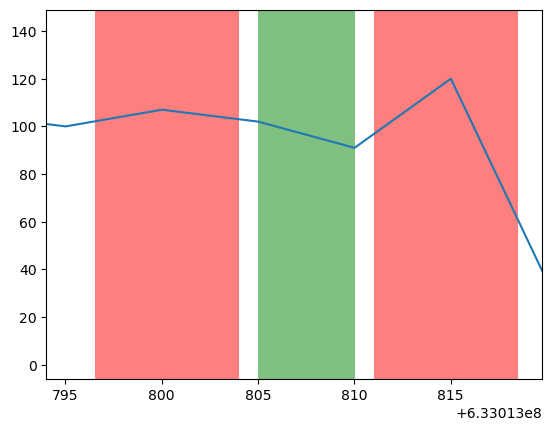

In [691]:
visualizeStarTS (starData, xmin=633013500, xmax=633014000, windowStart=633013805.01, windowSize=5)